## Calculate and scatterplot several indices using the differnce betw 2 30yr means of zonal mean zonal wind (calc in <insert Colin's script name here> )

## Indices calculated here include 
####   ZWRI (Zonal Wind Response Index), 
####   SPV (Strength of the Stratospheric Polar Vortex) and 
####   AA (Arctic Amplification) indices

##### Created as part of PAMIP group during CMIP6 hackathon 2021
##### Created by : Phoebe Hudson / Colin Manning


In [161]:
from itertools import chain
from itertools import islice
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import re
import os
import subprocess
import pickle
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# Set some plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

#!jupyter nbconvert --to script lpsd_scenariomip_ua_multimodel_pah.ipynb

In [8]:
### Create dictionary of historical model names (element 7) and associated ensemble members (element 9)

hist_model_data_dir = "/badc/cmip6/data/CMIP6/CMIP/*/*/historical/*/Amon/ua/gn/latest"
hist_data_in_dir_paths = glob(hist_model_data_dir)
hist_models = {}
for i in range(0,len(hist_data_in_dir_paths)):
    model_name = hist_data_in_dir_paths[i].split(sep='/')[7]
    if model_name not in hist_models:
        hist_models[model_name] = [hist_data_in_dir_paths[i].split(sep='/')[9]] # assign member to list
    else:
        hist_models[model_name].append(hist_data_in_dir_paths[i].split(sep='/')[9])
len(hist_models.keys())

40

In [9]:
### Create dictionary of ssp585 model names (element 7) and associated ensemble members (element 9)

rcp85_data_dir = "/badc/cmip6/data/CMIP6/ScenarioMIP/*/*/ssp585/*/Amon/ua/gn/latest"
data_in_dir_paths = glob(rcp85_data_dir)
rcp85_models = {}
for i in range(0,len(data_in_dir_paths)):
    model_name = data_in_dir_paths[i].split(sep='/')[7]
    if model_name not in rcp85_models:
        rcp85_models[model_name] = [data_in_dir_paths[i].split(sep='/')[9]] # assign member to list
    else:
        rcp85_models[model_name].append(data_in_dir_paths[i].split(sep='/')[9])
len(rcp85_models.keys())

29

In [12]:
### Turn the dictionary (rcp85_models, hist_models) into a list of model names

rcp85_models_list = list(rcp85_models.keys())
hist_models_list = list(hist_models.keys())
rcp85_models_list[24], rcp85_models_list[28], hist_models_list[29]
print(rcp85_models_list)

['TaiESM1', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'FGOALS-g3', 'IITM-ESM', 'CanESM5', 'CanESM5-CanOE', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'MPI-ESM1-2-HR', 'FIO-ESM-2-0', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2', 'CESM2-WACCM', 'NorESM2-LM', 'NorESM2-MM', 'NESM3', 'MCM-UA-1-0']


In [32]:
### Create list of 30 yr differences in zonal mean zonal wind for each model in both "hist_models" and "rcp85_models" dictionaries 
#      from previously calculated ensemble member 30yr mean DJF zonal mean zonal winds for
#     the "historical" simulation : over 1850-01-16 - 1880-12-16 and 
#     the "ssp585" experiment : over 1969-01-16 - 1999-12-16

diff_all_models = [] #np.zeros(len(hist_models)) #
model_name_fig = []
dt=0
for model in hist_models:
    print(dt, model)
    if (dt>0) : #&(dt!=28): #16:
        #model = list(hist_models.keys())[2]
        dm=0
        for member in hist_models[model]:
            if model in list(rcp85_models.keys()) and member in rcp85_models[model]:
                #print(model, member, dm)
                indir='/home/users/cjm317/CMIP6_Hackathon/Historical'
                infile=f'{model}_{member}_DJF_zonal_mean_ua_Amon_1981-2010.nc' #1850-1880.nc' #
                zm_hist = xr.open_mfdataset(f'{indir}/{infile}')

                indir='/home/users/cjm317/CMIP6_Hackathon/RCP85'
                infile=f'{model}_{member}_DJF_zonal_mean_ua_Amon_2070-2099.nc'
                
                try:
                    zm_rcp85 = xr.open_mfdataset(f'{indir}/{infile}')

                    if dm==0:
                        dt+=1
                        diff = zm_rcp85 - zm_hist
                        model_name_fig.append(model)
                    else:
                        diff_tmp = zm_hist - zm_rcp85
                        diff = diff + diff_tmp
                    dm+=1
                    #print(dm)
                except :
                    if dm==0:
                        dt+=1
                    print("Couldn't read "+f'{indir}/{infile}')
                    pass
        if dm > 0:
            diff = diff/dm
            diff['plev'] = diff.plev.values/100
            diff_all_models.append(diff)
    else: 
        dt+=1
        

0 TaiESM1
1 AWI-CM-1-1-MR
2 AWI-ESM-1-1-LR
2 BCC-CSM2-MR
3 BCC-ESM1
3 CAMS-CSM1-0
4 CAS-ESM2-0
5 FGOALS-g3
6 IITM-ESM
7 CanESM5
8 CanESM5-CanOE
9 CMCC-CM2-HR4
9 CMCC-CM2-SR5
10 CMCC-ESM2
11 ACCESS-ESM1-5
12 ACCESS-CM2
13 FIO-ESM-2-0
14 MPI-ESM-1-2-HAM
14 MIROC-ES2H
14 MIROC-ES2L
15 MIROC6
16 HadGEM3-GC31-LL
17 HadGEM3-GC31-MM
18 UKESM1-0-LL
Couldn't read /home/users/cjm317/CMIP6_Hackathon/RCP85/UKESM1-0-LL_r1i1p1f2_DJF_zonal_mean_ua_Amon_2070-2099.nc
20 MPI-ESM1-2-HR
21 MPI-ESM1-2-LR
22 MRI-ESM2-0
23 GISS-E2-1-G
24 GISS-E2-1-G-CC
24 GISS-E2-1-H
24 CESM2
25 CESM2-FV2
25 CESM2-WACCM
26 CESM2-WACCM-FV2
26 NorCPM1
26 NorESM2-LM
27 NorESM2-MM
28 NESM3
29 SAM0-UNICON
29 MCM-UA-1-0


In [31]:
#f'{indir}/{infile}'as213 
#!ncdump -h '{indir}/{infile}'
#model_name_fig, len(model_name_fig)

(['AWI-CM-1-1-MR',
  'BCC-CSM2-MR',
  'CAMS-CSM1-0',
  'CAS-ESM2-0',
  'FGOALS-g3',
  'IITM-ESM',
  'CanESM5',
  'CanESM5-CanOE',
  'CMCC-CM2-SR5',
  'CMCC-ESM2',
  'ACCESS-ESM1-5',
  'ACCESS-CM2',
  'FIO-ESM-2-0',
  'MIROC-ES2L',
  'MIROC6',
  'HadGEM3-GC31-LL',
  'HadGEM3-GC31-MM',
  'UKESM1-0-LL',
  'MPI-ESM1-2-HR',
  'MPI-ESM1-2-LR',
  'MRI-ESM2-0',
  'GISS-E2-1-G',
  'CESM2',
  'CESM2-WACCM',
  'NorESM2-LM',
  'NorESM2-MM',
  'NESM3',
  'MCM-UA-1-0'],
 28)

In [34]:
#Load in temperature data
### Create list of 30 yr mean 2m temperature data from models in both "hist_models" and "rcp85_models" dictionaries

# Calculate zonal mean 2m temperature (mean over all longitudes) and sub-select by latitude (N hem = 0,90)
# Select winter months (DJF=Dec-Feb) from zonal mean 2m temp
# Calculate difference between two 30-yr means of zonal mean 2m temp for
#     the "historical" simulation : over 1850-01-16 - 1880-12-16 and 
#     the "ssp585" experiment : over 1969-01-16 - 1999-12-16

ds_temp_all_models_list = []
temp_model_name_fig = []
for model in rcp85_models: #islice(rcp85_models,20,29) : #islice(models,29):
    i=0
    print(model)
    for member in rcp85_models[model] : #, 24:
        #print(model)
        if model == 'MRI-ESM2-0':
            forc_model_data_in_dir_paths = ['/badc/cmip6/data/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp585/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_MRI-ESM2-0_ssp585_r1i1p1f1_gn_201501-210012.nc']
        else:
            forc_model_data_dir = "/badc/cmip6/data/CMIP6/ScenarioMIP/*/"+ str(model)+'/ssp585/'+str(member)+'/Amon/tas/gn/latest/*'
            forc_model_data_in_dir_paths = glob(forc_model_data_dir)
        #forc_model_data_dir = "/badc/cmip6/data/CMIP6/ScenarioMIP/*/"+ str(model)+'/ssp585/'+str(member)+'/Amon/tas/gn/latest/*'
        hist_model_data_dir = "/badc/cmip6/data/CMIP6/CMIP/*/"+ str(model)+'/historical/'+str(member)+'/Amon/tas/gn/latest/*'
        #forc_model_data_in_dir_paths = glob(forc_model_data_dir)
        hist_model_data_in_dir_paths = glob(hist_model_data_dir)
        if (len(forc_model_data_in_dir_paths)>0) & (len(hist_model_data_in_dir_paths))>0 :
            hist_endtime = str(hist_model_data_in_dir_paths[-1])[-9:-3]
            forc_starttime = str(forc_model_data_in_dir_paths[0])[-16:-10]
            if hist_endtime>forc_starttime :
                model_data_in_dir_paths_all = forc_model_data_in_dir_paths + hist_model_data_in_dir_paths[:-1]
            else :
                model_data_in_dir_paths_all = forc_model_data_in_dir_paths + hist_model_data_in_dir_paths
            #print(len(model_data_in_dir_paths_all))
            ds_n = xr.open_mfdataset(model_data_in_dir_paths_all)
            #print(ds_n)
            if int(str(ds_n.time[-1].values)[0:4]) >= 2099 :
            #have it make sure that last time is 2099-12 before computing
                try : #exists(ds['latitude']):
                    ds_n = ds_n.rename({'latitude':'lat', 'longitude':'lon'})
                except ValueError : 
                    pass
                ds_n = ds_n.mean(dim='lon') #.sel(lat=slice(0, 90))
                is_winter = ds_n['time'].dt.season == 'DJF'
                ds_n_winter = ds_n.isel(time=is_winter)
                ds_n_endyrs = ds_n_winter.sel(time=slice('2069-01-16', '2099-12-16')).mean(dim='time')
                ds_n_startyrs = ds_n_winter.sel(time=slice('1981-01-16', '2010-12-16')).mean(dim='time') #(time=slice('1850-01-16', '1880-12-16')).mean(dim='time')
                #calculate change in temperature everywhere
                ds_n_yrsdiff = ds_n_endyrs - ds_n_startyrs
                if i==0 : 
                    ds_temp = ds_n_yrsdiff
                if i>0 : 
                    ds_temp = ds_temp + ds_n_yrsdiff
                i+=1
    ds_temp = ds_temp/i
    temp_model_name_fig.append(model)
    ds_temp_all_models_list.append(ds_temp)
    
    ### Alternative to a list is to write out datasets (ds_t) to netcdf 
    #      datasets as a list makes the above script quicker BUT takes longer to plot (below)
    #      datasets saved as netcdf files is quicker to plot BUT it takes longer to create the files
    #   If you want to create netcdf files - look at Colin's script + submit a LOTUS batch job
    
    #ds_t.to_netcdf('/gws/pw/j05/cop26_hackathons/bristol/project05/cmip6_zonal_ensemble_mean/'+str(model)+'_ensmean_DJF_zonal_mean_ua_Amon_diff_2069-2099_1850-1880.nc')
    #ds_t.to_netcdf('/home/users/phohud/pah_phd_scripts/cmip6_hack/cmip6_zonal_ensmean/'+str(model)+'_ensmean_DJF_zonal_mean_ua_Amon_diff_2069-2099_1850-1880.nc')
    
   

TaiESM1
AWI-CM-1-1-MR
BCC-CSM2-MR
CAMS-CSM1-0
CAS-ESM2-0
FGOALS-g3
IITM-ESM
CanESM5
CanESM5-CanOE
CMCC-CM2-SR5
CMCC-ESM2
ACCESS-ESM1-5
ACCESS-CM2
MPI-ESM1-2-HR
FIO-ESM-2-0
MIROC-ES2L
MIROC6
HadGEM3-GC31-LL
HadGEM3-GC31-MM
UKESM1-0-LL
MPI-ESM1-2-LR
MRI-ESM2-0
GISS-E2-1-G
CESM2


/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM


/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


NorESM2-LM
NorESM2-MM
NESM3
MCM-UA-1-0


In [ ]:
#hist_model_data_in_dir_paths, forc_model_data_in_dir_paths
#hist_endtime, forc_starttime

In [33]:
#len(ds_temp_all_models_list)

29

In [108]:
%%time
### Calculate index for Arctic Amplification (AA) using difference betw "ssp585" and "historical" zonal mean DJF 2m temperature data
#     index calculated as difference betw 2 boxes over an Arctic latitude band (70-90N) and a reference latitude band (0-90N)

#Set region of boxes
aa_lat_box_a_min = 70 #65
aa_lat_box_a_max = 90
aa_lat_box_ml_max = 0 #25
aa_lat_box_ml_min = -90

#zwri = np.zeros(len(diff_all_models))
#spv = np.zeros(len(diff_all_models))
aa_ind_dict = {}
aa_ind_arctic_all = {} #np.zeros(len(ds_temp_all_models_list)) 
aa_ind = np.zeros(len(ds_temp_all_models_list)) 

for i in range(len(ds_temp_all_models_list)):
    aa_ind_arctic = ds_temp_all_models_list[i].sel(lat=slice(aa_lat_box_a_min, aa_lat_box_a_max)).mean('lat')
    aa_ind_midlat = ds_temp_all_models_list[i].sel(lat=slice(aa_lat_box_ml_min, aa_lat_box_ml_max)).mean('lat')
    aa_ind_i = aa_ind_arctic/aa_ind_midlat
    #this next line takes a while to run
    #aa_ind_arctic_all[i]=aa_ind_arctic.tas.values
    aa_ind_arctic_all[temp_model_name_fig[i]]=aa_ind_arctic.tas.values
    aa_ind[i]=aa_ind_i.tas.values
    aa_ind_dict[temp_model_name_fig[i]] = float(aa_ind[i]) #float(aa_ind_i.tas.values)
aa_ind

/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/dask/array/core.py:4403: RuntimeWarning: invalid value encountered in float_scalars
  result = function(*args, **kwargs)
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/dask/array/core.py:4403: RuntimeWarning: invalid value encountered in float_scalars
  result = function(*args, **kwargs)
/gws/pw/j05/cop26_hackathons/bri

CPU times: user 4min 4s, sys: 1min 39s, total: 5min 43s
Wall time: 4min 51s


array([2.25039363, 2.1396637 , 2.09347868, 1.72707868, 1.99864948,
       2.25490165, 2.07458115, 2.28475881, 2.29735708, 2.12051511,
       2.18337035, 2.23951197, 2.23336053, 2.30544329, 2.32625508,
       2.2895391 ,        nan,        nan,        nan,        nan,
       2.16845989, 2.35212302,        nan, 2.08516359, 2.10667777,
       1.89850283, 1.91403651, 2.36388183, 2.08149099])

In [44]:
#float(aa_ind_i.tas.values)

2.058245897293091

In [ ]:
#diff_all_models[0]
#zwri_n = diff_all_models[0].sel(plev=slice(plev_max, plev_min)).sel(lat=slice(lat_box2_min, lat_box2_max)).mean('lat').mean('plev')
#zwri_s = diff_all_models[0].sel(plev=slice(plev_max, plev_min)).sel(lat=slice(lat_box1_min, lat_box1_max)).mean('lat').mean('plev')
#zwri_i = zwri_n - zwri_s
#zwri_i.ua.values

In [109]:
%%time 
### Calculate ZWRI (zonal wind response index) and SPV (strength of stratospheric polar vortex) using difference betw "ssp585" and "historical" DJF zonal mean zonal wind
#     index calculated as difference betw 2 boxes (30-39N and 54-63N)

#Set region of box
plev_min = 150
plev_max = 600
zwri_lat_box1_min = 30
zwri_lat_box1_max = 39
zwri_lat_box2_min = 54
zwri_lat_box2_max = 63


zwri = np.zeros(len(diff_all_models))
zwri_n_all = {}
zwri_dict = {}
spv = np.zeros(len(diff_all_models))
spv_dict = {}

for i in range(len(diff_all_models)):
    zwri_n = diff_all_models[i].sel(plev=slice(plev_max, plev_min)).sel(lat=slice(zwri_lat_box2_min, zwri_lat_box2_max)).mean('lat').mean('plev')
    zwri_s = diff_all_models[i].sel(plev=slice(plev_max, plev_min)).sel(lat=slice(zwri_lat_box1_min, zwri_lat_box1_max)).mean('lat').mean('plev')
    zwri_i = zwri_n - zwri_s
    spv_i = diff_all_models[i].sel(plev=10, method='nearest').sel(lat=slice(54, 66)).mean('lat') #.mean('plev')
    #print(zwri_i.ua.values, spv_i)
    zwri[i] = zwri_i.ua.values
    zwri_n_all[model_name_fig[i]] = zwri_n.ua.values
    spv[i] = spv_i.ua.values
    zwri_dict[model_name_fig[i]] = float(zwri[i])
    spv_dict[model_name_fig[i]] = float(spv[i])
        
zwri
spv

/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 2.13 s, sys: 307 ms, total: 2.43 s
Wall time: 3.52 s


/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array([-0.46375746, -2.29991913, -2.0794704 ,  2.61464143, -0.48169097,
       -2.91834998, -8.62561417,  5.7635603 ,  6.31838655,  3.73977327,
        1.72597277,  6.59243011,  3.50075006,  3.66399622,  0.72927344,
       -2.08102417, -3.8581779 ,         nan,  0.70861423,  1.46322381,
        4.39268827,  5.82512426,  0.17979871,  1.19537878,  3.77655268,
       -0.97157216,  3.95087218,         nan])

In [122]:
#diff_all_models[0]
#spv = diff_all_models[0].sel(plev=10, method='nearest').sel(lat=slice(54, 66)).mean('lat') #.mean('plev')
#spv #.ua.values
#np.nanmin(np.asarray(list(zwri_n_all.values())))

-1.3748487

29 28
0.0218604365968435
SpearmanrResult(correlation=0.39243365330321855, pvalue=0.07084079067181391)


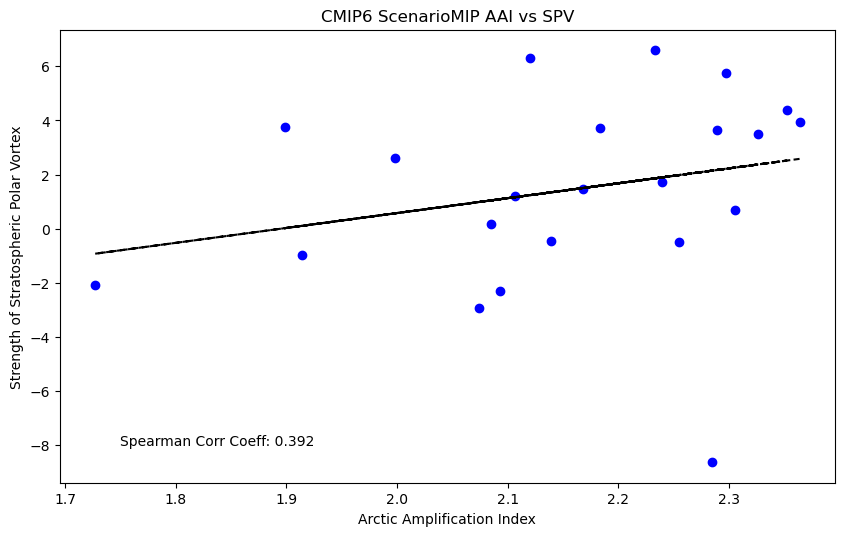

In [193]:
### Scatterplot Arctic Amplification index vs SPV

print(len(aa_ind), len(spv))

aa_ind_list = []
spv_list = []

#overlay historical mean zonal wind as color
#cmap=plt.get_cmap('Spectral') #('rainbow')

#aa_ind_arctic_all

fig, axes = plt.subplots() 
for model in aa_ind_dict :
    try :
        spv_dict[model]
        plt.scatter(aa_ind_dict[model], spv_dict[model], c='b') #, c=cmap(zwri_dict[model]/np.nanmean(zwri)))
        if np.isnan(aa_ind_dict[model]) or np.isnan(spv_dict[model]):
            pass
        else :
            aa_ind_list.append(aa_ind_dict[model])
            spv_list.append(spv_dict[model])
    except :
        pass
m1, b1 = np.polyfit(aa_ind_list, spv_list, 1)
c1 = spearmanr(aa_ind_list, spv_list) #pearsonr
cov = np.cov(aa_ind_list, spv_list)
print(cov[0,1]**2)
#plt.scatter(aa_ind, spv)
print(c1)
plt.plot(np.asarray(aa_ind_list), np.asarray(aa_ind_list)*m1+b1, '--k')
plt.xlabel('Arctic Amplification Index')
plt.ylabel('Strength of Stratospheric Polar Vortex')
plt.title('CMIP6 ScenarioMIP AAI vs SPV')
plt.text(1.75, -8,('Spearman Corr Coeff: '+str(round(c1[0],3))))
figdir = '/home/users/phohud/pah_phd_scripts/cmip6_hack/project05/results/'
fig.savefig((figdir+'cmip6_AAI_SPV_scen585_2069-2099_hist_1981-2010_aai'+str(aa_lat_box_a_min)+'-'+str(aa_lat_box_a_max)+'_mli'+str(aa_lat_box_ml_min)+'-'+str(aa_lat_box_ml_max)+'N.png'), dpi=100, transparent=False, bbox_inches='tight', pad_inches=0.1)


In [177]:
#'Spearman Corr Coeff: {1:02d}'.format(c1[0])
#c1[0]

0.39243365330321855

29 28
SpearmanrResult(correlation=-0.21047430830039524, pvalue=0.33506327271090686)


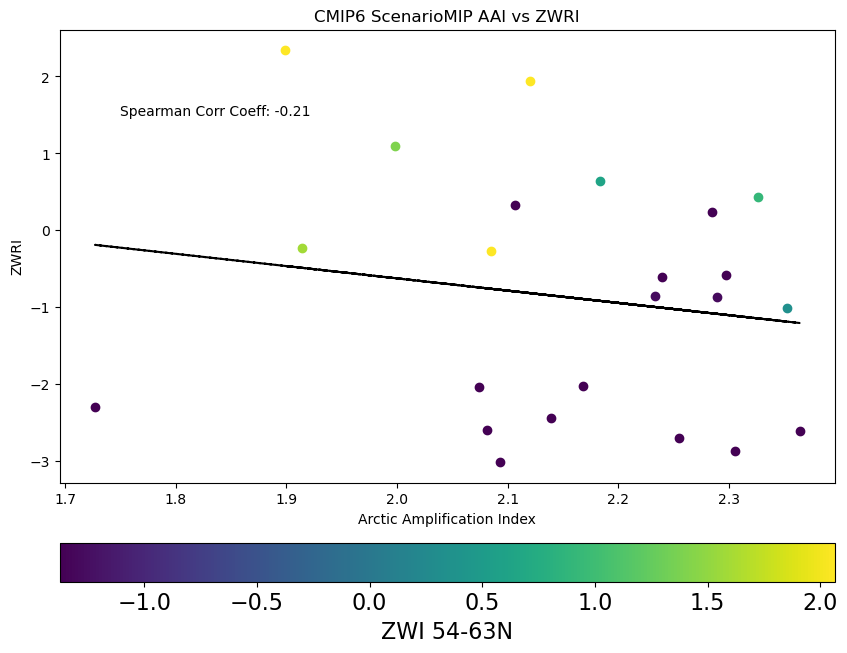

In [185]:
### Scatterplot Arctic Amplification index vs ZWRI 
#     with zonal mean response in the higher latitude box (ZWI) denoted by the point color

print(len(aa_ind), len(zwri))
fig, ax = plt.subplots(figsize=(10,8)) 
#plt.scatter(aa_ind, zwri)

aa_ind_list = []
zwri_list = []

cmap=plt.get_cmap('viridis') #'Spectral') #('rainbow')
vmin = np.nanmin(np.asarray(list(zwri_n_all.values())))
vmax = np.nanmax(np.asarray(list(zwri_n_all.values())))
normalize=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

#aa_ind_arctic_all
for model in aa_ind_dict :
    try :
        zwri_dict[model]
        plt.scatter(aa_ind_dict[model], zwri_dict[model], color=cmap(zwri_n_all[model]), norm=normalize) #'b')
        if np.isnan(aa_ind_dict[model]) or np.isnan(zwri_dict[model]):
            pass
        else :
            aa_ind_list.append(aa_ind_dict[model])
            zwri_list.append(zwri_dict[model])
    except :
        pass
m1, b1 = np.polyfit(aa_ind_list, zwri_list, 1)
c1 = spearmanr(aa_ind_list, zwri_list) #pearsonr
#plt.scatter(aa_ind, spv)
print(c1)
plt.plot(np.asarray(aa_ind_list), np.asarray(aa_ind_list)*m1+b1, '--k')
plt.xlabel('Arctic Amplification Index')
plt.ylabel('ZWRI')
plt.title('CMIP6 ScenarioMIP AAI vs ZWRI')
plt.text(1.75, 1.5,('Spearman Corr Coeff: '+str(round(c1[0],3))))
cax, _ = matplotlib.colorbar.make_axes(ax, orientation="horizontal",pad=0.1)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,orientation="horizontal")
cbar.set_label('ZWI '+str(zwri_lat_box2_min)+'-'+str(zwri_lat_box2_max)+'N',size=16)
cbar.ax.tick_params(labelsize=16)

figdir = '/home/users/phohud/pah_phd_scripts/cmip6_hack/project05/results/'
fig.savefig((figdir+'cmip6_AAI_ZWRI_scen585_2069-2099_hist_1981-2010_co_aai'+str(aa_lat_box_a_min)+'-'+str(aa_lat_box_a_max)+'_mli'+str(aa_lat_box_ml_min)+'-'+str(aa_lat_box_ml_max)+'N.png'), dpi=100, transparent=False, bbox_inches='tight', pad_inches=0.1)


29 28
SpearmanrResult(correlation=-0.3325804630152457, pvalue=0.13045381101860304)


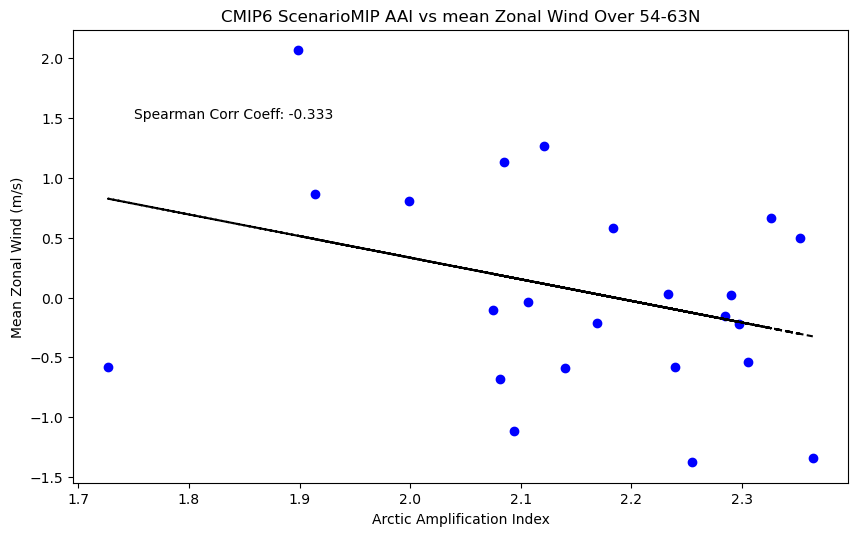

In [186]:
### Scatterplot ZWRI vs zonal mean response in the higher latitude box (ZWI)

print(len(aa_ind), len(zwri))
fig, axes = plt.subplots() 
#plt.scatter(aa_ind, zwri)

aa_ind_list = []
zwri_n_list = []

for model in aa_ind_dict :
    try :
        zwri_dict[model]
        plt.scatter(aa_ind_dict[model], zwri_n_all[model], c='b')
        if np.isnan(aa_ind_dict[model]) or np.isnan(spv_dict[model]):
            pass
        else :
            aa_ind_list.append(aa_ind_dict[model])
            zwri_n_list.append(zwri_n_all[model])
    except :
        pass
m1, b1 = np.polyfit(aa_ind_list, zwri_n_list, 1)
c1 = spearmanr(aa_ind_list, zwri_n_list) #pearsonr
#plt.scatter(aa_ind, spv)
print(c1)
plt.plot(np.asarray(aa_ind_list), np.asarray(aa_ind_list)*m1+b1, '--k')
plt.xlabel('Arctic Amplification Index')
plt.ylabel('Mean Zonal Wind (m/s)')
plt.title('CMIP6 ScenarioMIP AAI vs mean Zonal Wind Over '+str(zwri_lat_box2_min)+'-'+str(zwri_lat_box2_max)+'N')
plt.text(1.75, 1.5,('Spearman Corr Coeff: '+str(round(c1[0],3))))
figdir = '/home/users/phohud/pah_phd_scripts/cmip6_hack/project05/results/'
fig.savefig((figdir+'cmip6_AAI_ZWI_scen585_2069-2099_hist_1981-2010_aai'+str(aa_lat_box_a_min)+'-'+str(aa_lat_box_a_max)+'_mli'+str(aa_lat_box_ml_min)+'-'+str(aa_lat_box_ml_max)+'N.png'), dpi=100, transparent=False, bbox_inches='tight', pad_inches=0.1)


In [195]:
#aa_ind_dict
#zwri_dict

{'AWI-CM-1-1-MR': -2.445075035095215,
 'BCC-CSM2-MR': -3.0192830562591553,
 'CAMS-CSM1-0': -2.308213710784912,
 'CAS-ESM2-0': 1.0902020931243896,
 'FGOALS-g3': -2.7104544639587402,
 'IITM-ESM': -2.048552989959717,
 'CanESM5': 0.22958306968212128,
 'CanESM5-CanOE': -0.586239755153656,
 'CMCC-CM2-SR5': 1.9439401626586914,
 'CMCC-ESM2': 0.6401281952857971,
 'ACCESS-ESM1-5': -0.6160816550254822,
 'ACCESS-CM2': -0.8573334813117981,
 'FIO-ESM-2-0': 0.4291418492794037,
 'MIROC-ES2L': -0.8678706288337708,
 'MIROC6': 0.08431855589151382,
 'HadGEM3-GC31-LL': 1.4367237091064453,
 'HadGEM3-GC31-MM': 0.30503106117248535,
 'UKESM1-0-LL': nan,
 'MPI-ESM1-2-HR': -2.8767242431640625,
 'MPI-ESM1-2-LR': -2.0285301208496094,
 'MRI-ESM2-0': -1.012099266052246,
 'GISS-E2-1-G': -0.05359220504760742,
 'CESM2': -0.274255633354187,
 'CESM2-WACCM': 0.3303643465042114,
 'NorESM2-LM': 2.3423349857330322,
 'NorESM2-MM': -0.2359457015991211,
 'NESM3': -2.6223576068878174,
 'MCM-UA-1-0': -2.6075809001922607}

In [95]:
### Save AAI, ZWRI, SPV indices (dictionaries) as .pkl files

outdir = '/home/users/phohud/pah_phd_scripts/cmip6_hack/project05/data/'
outfilea = 'aa_ind_cmip6_scenariomip_scen585_2069-2099_hist_1981-2010_box_'+str(aa_lat_box_a_min)+'-'+str(aa_lat_box_a_max)+'mli_'+str(aa_lat_box_ml_min)+'-'+str(aa_lat_box_ml_max)+'N.pkl'
with open("{}/{}".format(outdir, outfile), "wb") as fp:
         pickle.dump(aa_ind_dict, fp)
#spv
outfileb = 'spv_ind_cmip6_scenariomip_scen585_2069-2099_hist_1981-2010.pkl'
with open("{}/{}".format(outdir, outfile), "wb") as fp:
         pickle.dump(spv_dict, fp)
#zwri
outfilec = 'zwri_ind_cmip6_scenariomip_scen585_2069-2099_hist_1981-2010.pkl'
with open("{}/{}".format(outdir, outfile), "wb") as fp:
         pickle.dump(zwri_dict, fp)

In [84]:
### Test loading the dictionary indiced files back in 

outdir = '/gws/pw/j05/cop26_hackathons/bristol/project05/project05/data'
outfile_aa = 'aa_ind_cmip6_scenariomip_scen585_2069-2099_hist_1981-2010_box_'+str(aa_lat_box_a_min)+'-'+str(aa_lat_box_a_max)+'mli_'+str(aa_lat_box_ml_min)+'-'+str(aa_lat_box_ml_max)+'N.pkl'
outfile_spv = 'spv_ind_cmip6_scenariomip_scen585_2069-2099_hist_1981-2010.pkl'
outfile_zwri = 'zwri_ind_cmip6_scenariomip_scen585_2069-2099_hist_1981-2010.pkl'

with open("{}/{}".format(outdir, outfile_spv), "rb") as fp:
         a = pickle.load(fp)
a

{'AWI-CM-1-1-MR': -0.4637574553489685,
 'BCC-CSM2-MR': -2.2999191284179688,
 'CAMS-CSM1-0': -2.07947039604187,
 'CAS-ESM2-0': 2.6146414279937744,
 'FGOALS-g3': -0.4816909730434418,
 'IITM-ESM': -2.9183499813079834,
 'CanESM5': -8.625614166259766,
 'CanESM5-CanOE': 5.7635602951049805,
 'CMCC-CM2-SR5': 6.318386554718018,
 'CMCC-ESM2': 3.7397732734680176,
 'ACCESS-ESM1-5': 1.7259727716445923,
 'ACCESS-CM2': 6.592430114746094,
 'FIO-ESM-2-0': 3.5007500648498535,
 'MIROC-ES2L': 3.6639962196350098,
 'MIROC6': 0.7292734384536743,
 'HadGEM3-GC31-LL': -2.081024169921875,
 'HadGEM3-GC31-MM': -3.858177900314331,
 'UKESM1-0-LL': nan,
 'MPI-ESM1-2-HR': 0.7086142301559448,
 'MPI-ESM1-2-LR': 1.4632238149642944,
 'MRI-ESM2-0': 4.392688274383545,
 'GISS-E2-1-G': 5.825124263763428,
 'CESM2': 0.17979870736598969,
 'CESM2-WACCM': 1.1953787803649902,
 'NorESM2-LM': 3.776552677154541,
 'NorESM2-MM': -0.9715721607208252,
 'NESM3': 3.9508721828460693,
 'MCM-UA-1-0': nan}